In [5]:
import os
os.environ["HUGGINGFACE_HUB_CACHE"] = "/data/sshadmin/bocheng/.cache/huggingface/hub/"
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision


def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import os

os.environ["HUGGINGFACE_HUB_CACHE"] = "/data/sshadmin/bocheng/.cache/huggingface/hub/"

from diffusers import StableDiffusionPipeline

# os.environ["HUGGINGFACE_HUB_CACHE"] = ""
# https://huggingface.co/sd-dreambooth-library ，这里有来自社区的各种模型

model_id = "sd-dreambooth-library/mr-potato-head"
pipe=StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

safety_checker/model.safetensors not found
Loading pipeline components...:  71%|███████▏  | 5/7 [00:02<00:01,  1.68it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


100%|██████████| 50/50 [00:02<00:00, 24.18it/s]


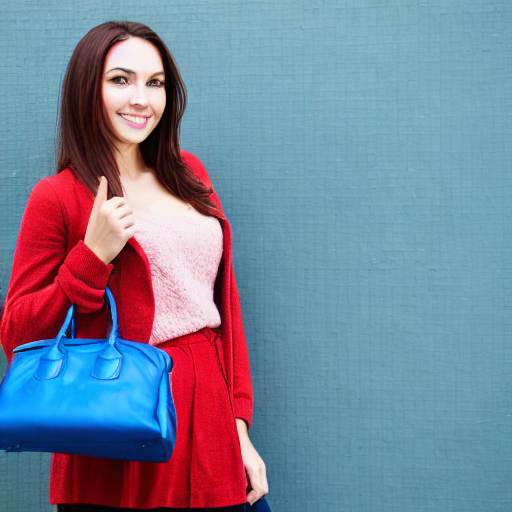

In [7]:
prompt = "a beaufiful girl with a bag in hand"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image

In [1]:
import os

# 修改环境变量要在导入datasets或者transformers模块之前
os.environ["XDG_CACHE_HOME"] = "/data/sshadmin/bocheng/.cache"
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train",cache_dir="/data/sshadmin/bocheng/.cache/huggingface/datasets")

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
Generating train split: 100%|██████████| 1000/1000 [00:00<00:00, 1028.99 examples/s]


In [2]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [3]:
image_size=32
batch_size=64
preprocess=transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

def transform(examples):
    images=[preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images":images}

dataset.set_transform(transform)

In [8]:
train_dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)


X shape: torch.Size([8, 3, 32, 32])


/tmp/ipykernel_2051247/972932828.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(xb).resize((8*64,64),resample=Image.NEAREST)


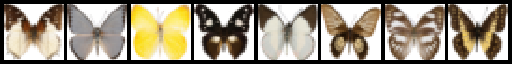

In [9]:
xb=next(iter(train_dataloader))['images'].to(device)[:8]
print("X shape:",xb.shape)
show_images(xb).resize((8*64,64),resample=Image.NEAREST)


In [13]:
from diffusers.schedulers import DDPMScheduler
noise_scheduler=DDPMScheduler(num_train_timesteps=1000,beta_start=0.001,beta_end=0.004)

In [16]:
timesteps=torch.linspace(0,999,8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

Noisy x shape torch.Size([8, 3, 32, 32])


/tmp/ipykernel_2051247/3933001287.py:4: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(noisy_xb).resize((8*64,64),resample=Image.NEAREST)


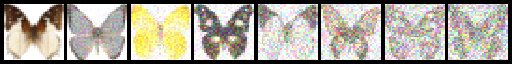

In [17]:
noise=torch.rand_like(xb)
noisy_xb=noise_scheduler.add_noise(xb,noise,timesteps)
print("Noisy x shape",noisy_xb.shape)
show_images(noisy_xb).resize((8*64,64),resample=Image.NEAREST)

In [18]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",  # 一个常规的ResNet下采样模块
        "DownBlock2D",
        "AttnDownBlock2D",  # 一个带有空间自注意力的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # 一个带有空间自注意力的ResNet上采样模块
        "UpBlock2D",
        "UpBlock2D",  # 一个常规的ResNet上采样模块
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

In [20]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []
for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.14298165868967772
Epoch:10, loss: 0.11957958107814193
Epoch:15, loss: 0.09735506074503064
Epoch:20, loss: 0.08431908255442977
Epoch:25, loss: 0.08439601794816554
Epoch:30, loss: 0.0707802907563746


100%|██████████| 1000/1000 [00:15<00:00, 65.31it/s]


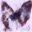

In [22]:
from diffusers import DDPMPipeline
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]